In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
%env GOOGLE_APPLICATION_CREDENTIALS='sa.json'
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# 转换为独热编码
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

env: GOOGLE_APPLICATION_CREDENTIALS='sa.json'


2021-12-08 15:26:13.588393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 15:26:13.588420: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

(42000,)
(42000, 784)


/home/yb/Ynov/mlflow/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

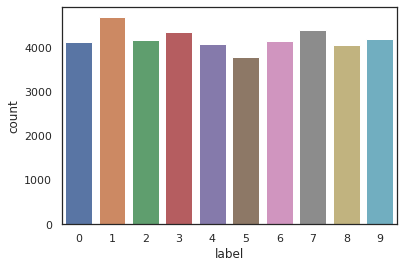

In [3]:
# 'label'
Y_train = train["label"]
print(Y_train.shape)

X_train = train.drop(labels = ["label"],axis = 1) 
print(X_train.shape)

del train

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
X_train = X_train / 255.0
test = test / 255.0

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)


In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
random_seed = 2

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

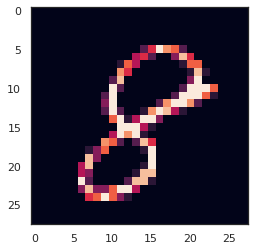

In [10]:
g = plt.imshow(X_train[0][:,:,0])

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

2021-12-08 15:26:18.497391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 15:26:18.497428: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 15:26:18.497455: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yb-debian): /proc/driver/nvidia/version does not exist
2021-12-08 15:26:18.497732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs =  1 #30 for best result, used 1 for time
batch_size = 86

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  			
        samplewise_center=False,  			
        featurewise_std_normalization=False,   
        samplewise_std_normalization=False,  
        zca_whitening=False,  				
        rotation_range=10,  				
        zoom_range = 0.1, 					
        width_shift_range=0.1,  			
        height_shift_range=0.1,  			
        horizontal_flip=False,  			
        vertical_flip=False)  				


datagen.fit(X_train)

In [16]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])
# 8 minutes

/tmp/ipykernel_11258/777752576.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 521s - loss: 0.3589 - accuracy: 0.8929 - val_loss: 0.4216 - val_accuracy: 0.8774 - lr: 0.0010 - 521s/epoch - 1s/step


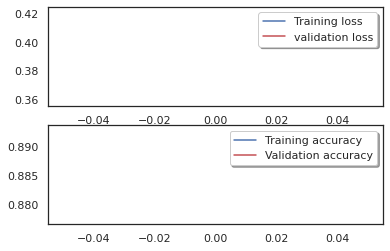

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

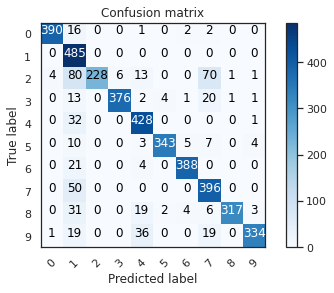

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    此函数打印并绘制混淆矩阵
	可以通过设置 “normalize=true” 应用归一化
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 从验证数据集中预测值
Y_pred = model.predict(X_val)
# 将预测类转换为一个独热向量
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 将验证观测转换为一个独热向量
Y_true = np.argmax(Y_val,axis = 1) 
# 计算混淆矩阵
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

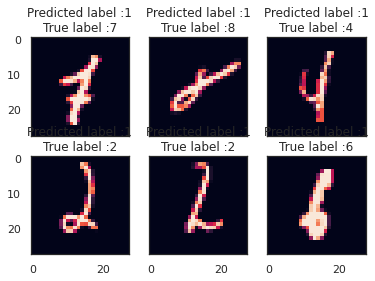

In [21]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """
    此函数显示6个图像及其预测和实际标签
    """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# 错误预测数的概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# 误差集中真值的预测概率
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# 预测标签概率与真实标签概率之差
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# 对预测标签概率与真实标签概率之差的列表进行排序
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6错误
most_important_errors = sorted_dela_errors[-6:]

# 展示Top 6错误
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [ ]:
results = model.predict(test)

# 选择最大概率的整数
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)